#IMDB Sentiment Analysis - BERT model
Georgios - Alexandros Vasilakopoulos

##Imports

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 27.0 MB/s eta 0:00:00


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 518.6/518.6 KB 9.4 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import Dataset
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from torchmetrics.classification import BinaryF1Score
from torchmetrics.classification import BinaryPrecision
from torchmetrics.classification import BinaryRecall
import matplotlib.pyplot as plt

##Loading the data:

In [ ]:
data_path = 'drive/MyDrive/ML/AI2/imdb-reviews.csv'
test_path = None #Insert the path here for testing and load the model below


if test_path:
    test_dataset = pd.read_csv(test_path, sep = '\t')
    X_test = test_dataset['review']
    Y_test = test_dataset[['rating']]
    Y_test.loc[Y_test['rating'] < 7.0, 'rating']=0
    Y_test.loc[Y_test['rating'] >= 7.0, 'rating']=1
else:
    data = pd.read_csv(data_path, sep = '\t')
    X = data['review']
    Y = data[['rating']]

    Y.loc[Y['rating'] < 7.0, 'rating']=0
    Y.loc[Y['rating'] >= 7.0, 'rating']=1

    X,X_test,Y,Y_test = train_test_split(X,Y,test_size=0.2, shuffle = True) #Partition of the dataset
    X,X_validation,Y,Y_validation = train_test_split(X,Y,test_size=0.2, shuffle = True)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


##Producing the Encodings through the BERT tokenizer

In [ ]:
def clean_text(X):      #Simple function for removing special characters and lower-casing letters
    X_transformed = []
    for instance in X:
        instance = re.sub(r'[^a-z ]+', '', instance.lower())
        X_transformed.append(instance)
    return X_transformed

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
if test_path is None:
    train_encodings = tokenizer(clean_text(X),truncation = True, padding = True, return_tensors='pt')
    validation_encodings = tokenizer(clean_text(X_validation),truncation = True, padding = True, return_tensors='pt')
test_encodings = tokenizer(clean_text(X_test),truncation = True, padding = True, return_tensors='pt')


##Defining a custom Dataset

In [ ]:
class ReviewDataset(Dataset):
    def __init__(self,X,Y):
        self.encodings = X
        self.Y = [int(i) for i in np.ravel(Y)]
        self.labels = torch.tensor(np.ravel(Y),dtype=torch.float)



    def __len__(self):
        return len(self.labels)

    def getLabels(self):
        return self.Y

    def __getitem__(self,idx):

        item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])

        return item


In [ ]:
if test_path is None:
    train_dataset = ReviewDataset(train_encodings,Y)
    validation_dataset = ReviewDataset(validation_encodings,Y_validation)
test_dataset = ReviewDataset(test_encodings,Y_test)

In [ ]:
if test_path is None:
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

##Testing Process

In [ ]:
def Test_Network(dataloader, model):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    f1 = BinaryF1Score().to(device)
    pr = BinaryPrecision().to(device)
    rec = BinaryRecall().to(device)

    with torch.no_grad():
        model.eval()
        batch_counter = 0
        f1_measure = 0
        precision = 0
        recall = 0
        for batch in dataloader:
            x = batch['input_ids'].to(device)
            y = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            prediction = model(x,attention_mask = attention_mask, labels = y)
            prediction = prediction[:,0]
            temp = f1(prediction,y)
            f1_measure += temp
            precision += pr(prediction,y)
            recall += rec(prediction,y)
            batch_counter +=1

        f1_measure/= batch_counter
        precision /= batch_counter
        recall /= batch_counter

    return precision, recall, f1_measure

In [ ]:
def make_prediction(test_dataloader,model):
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        model = model.cuda()

    predictions = []
    with torch.no_grad():
        model.eval()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        for batch in test_dataloader:
            x = batch['input_ids'].to(device)
            y = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            prediction = model(x,attention_mask = attention_mask, labels = y)
            prediction = prediction[:,0]
            predictions.append(np.array(prediction.cpu()))
        predictions = np.concatenate(predictions)
        quantized = []
        for val in predictions:
            if val>=0.5:
                quantized.append(1)
            else:
                quantized.append(0)

    return quantized


##Training Process

In [ ]:
def Train_Network(train_dataloader,validation_dataloader,n_epochs,lr,model,info=False):
    cost_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:
        print("Using cuda")
        model = model.cuda()
        cost_function = cost_function.cuda()
    else:
        print("Using CPU")

    best_model = None
    highest_f1_score = 0

    epoch_sizes = []
    val_scores = []
    train_scores = []

    for i in range(n_epochs):
        model.train()
        loss_list = []
        avg_losses = []
        for batch in train_dataloader:
            x = batch['input_ids'].to(device)
            y = batch['labels'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            optimizer.zero_grad()
            prediction = model(x,attention_mask = attention_mask, labels = y)
            loss = cost_function(prediction[:,0],y)
            loss_list.append(loss.item())
            loss.backward()
            optimizer.step()

        _,_,f1_measure_val = Test_Network(validation_dataloader,model)
        if info == True:
            _, _, f1_measure_train = Test_Network(train_dataloader,model)
            epoch_sizes.append([i])
            val_scores.append(f1_measure_val.item())
            train_scores.append(f1_measure_train.item())
            avg_losses.append(np.mean(loss_list))
    if info == False:
        return model, highest_f1_score
    return model, avg_losses, epoch_sizes, val_scores, train_scores



##Defining the structure of the classifier

In [ ]:
import torch.nn as nn

class BertBinaryClassifier(nn.Module):
    def __init__(self, bert_model,dim,dr):
        super(BertBinaryClassifier, self).__init__()

        self.bertlayer = BertModel.from_pretrained(bert_model)
        self.linearlayers = nn.Sequential(
            nn.Linear(768,dim),
            nn.ReLU(),
            nn.Dropout(dr),
            nn.Linear(dim,1),
        )
        self.sig = nn.Sigmoid()

    def forward(self,x,attention_mask,labels):
        bert_output = self.bertlayer(x,attention_mask = attention_mask)
        output = self.linearlayers(bert_output[1])
        output = self.sig(output)
        return output

##Training the classifier for 10 epochs
To determine ideal number of epochs to train for

In [ ]:
model = BertBinaryClassifier("bert-base-uncased",128,0.05)
print(model)

EPOCH = 10
model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, 0.000005, model,info = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertBinaryClassifier(
  (bertlayer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise

<ipython-input-7-0e99706d52e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-7-0e99706d52e6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


###Performance on the Test set: Metrics, Learning Curve

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

<ipython-input-7-0e99706d52e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-7-0e99706d52e6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Precision:  0.9586926698684692
Recall:  0.8993799686431885
f1 measure:  0.9256356954574585


The code below will work if the model is trained within the current runtime.

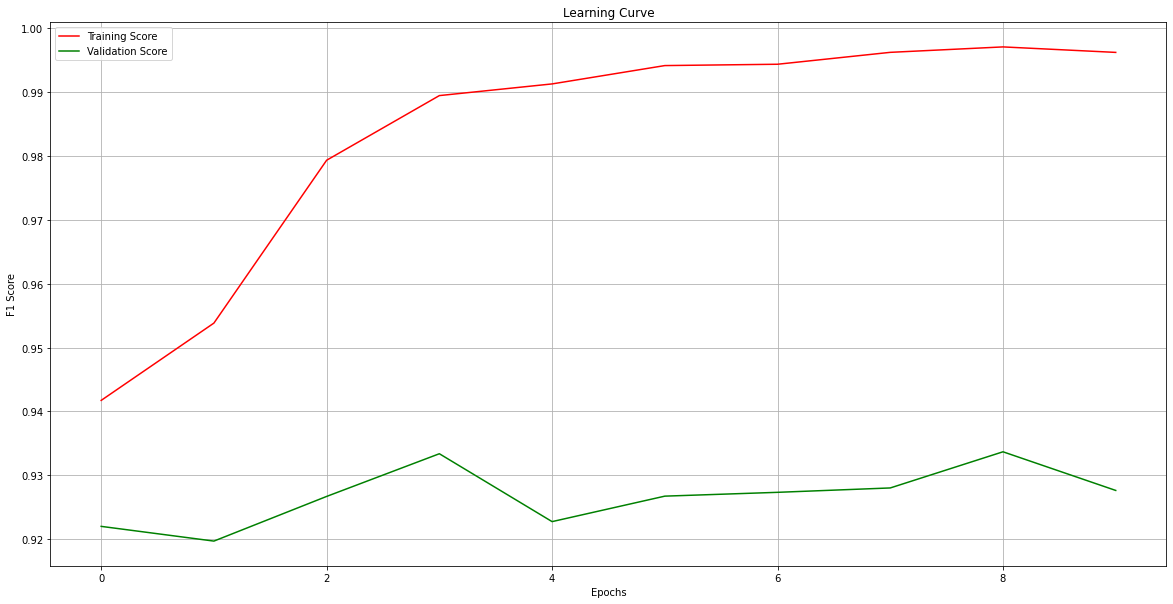

In [ ]:
_, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("Learning Curve")
axes.set_xlabel("Epochs")
axes.set_ylabel("F1 Score")
axes.grid()

axes.plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes.plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes.legend(loc="best")

##Training the model for 3 epochs

In [ ]:
model = BertBinaryClassifier("bert-base-uncased",128,0.05)

EPOCH = 3
model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, 0.000005, model,info = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Using cuda


<ipython-input-13-0e99706d52e6>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-13-0e99706d52e6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


###Performance on the Test set: Metrics, Learning Curve, ROC curve

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

<ipython-input-64-4ae427ad0939>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-64-4ae427ad0939>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Precision:  0.9358757138252258
Recall:  0.9636141657829285
f1 measure:  0.9479517936706543


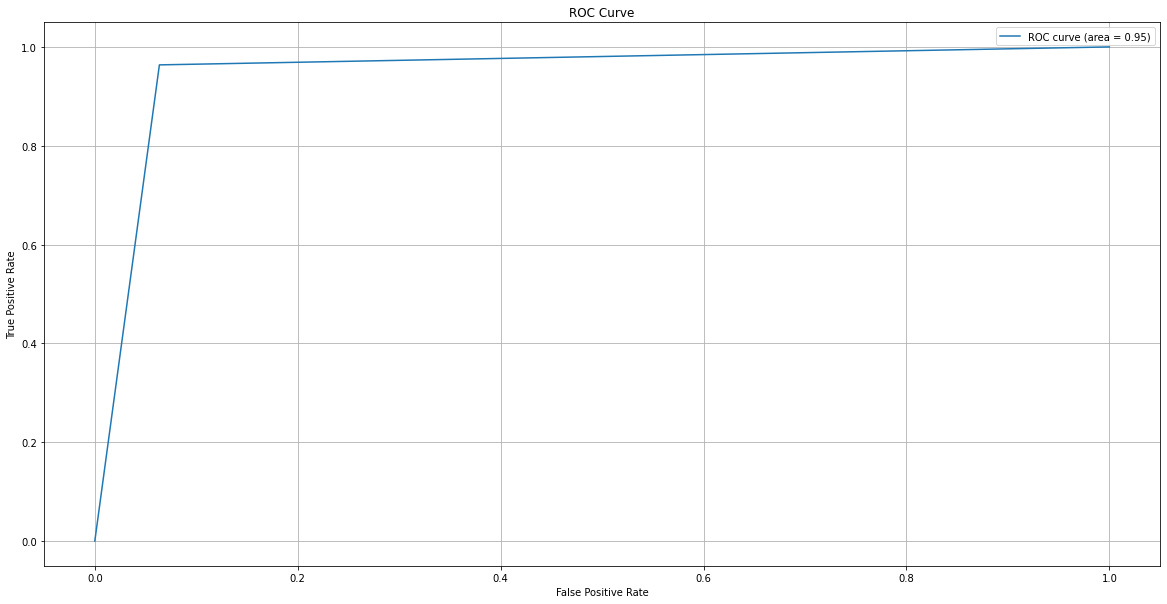

In [ ]:
from sklearn.metrics import roc_curve, auc
y_predicted = make_prediction(test_dataloader,model)
y_actual = test_dataset.getLabels()
fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("ROC Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid()
axes.plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes.legend(loc = "best")

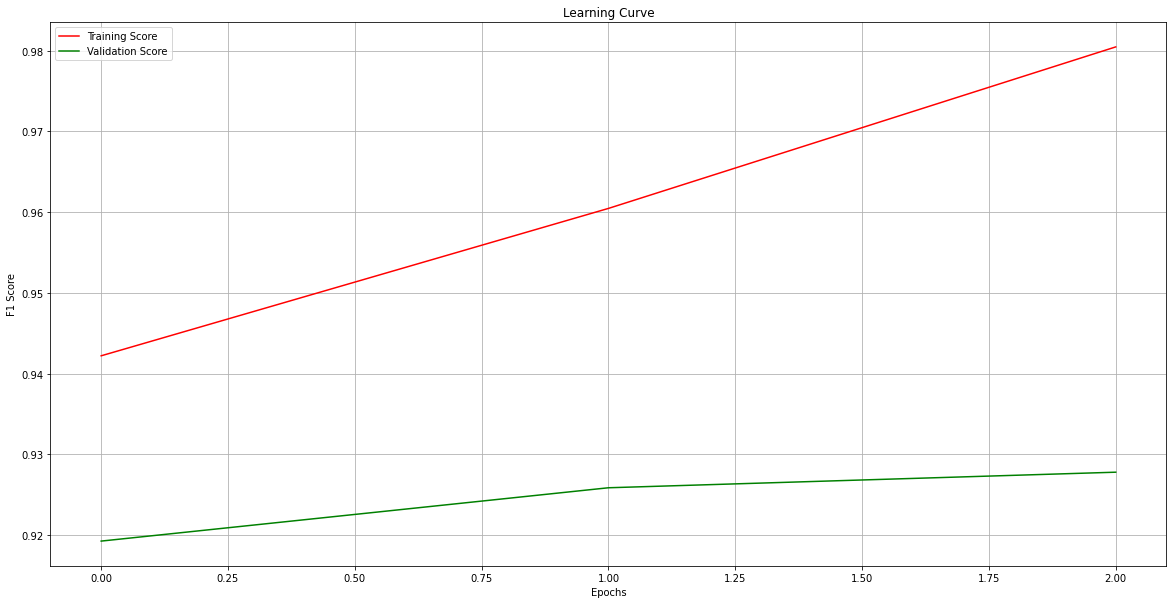

In [ ]:
_, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("Learning Curve")
axes.set_xlabel("Epochs")
axes.set_ylabel("F1 Score")
axes.grid()

axes.plot(epoch_sizes, train_scores, color = "r", label = "Training Score")
axes.plot(epoch_sizes, val_scores, color = "g", label = "Validation Score")
axes.legend(loc="best")

###Saving the model

In [ ]:
PATH = 'drive/MyDrive/ML/AI2/'

In [ ]:
torch.save(model.state_dict(),PATH + 'myBERTmodel.pt')

#Alternative Architecture


###2 Layered Model definition

In [ ]:
class BERT2Layers(nn.Module):
    def __init__(self, bert_model,dim1,dim2,dr):
        super(BERT2Layers, self).__init__()

        self.bertlayer = BertModel.from_pretrained(bert_model)
        self.linearlayers = nn.Sequential(
            nn.Linear(768,dim1),
            nn.ReLU(),
            nn.Dropout(dr),
            nn.Linear(dim1,dim2),
            nn.ReLU(),
            nn.Dropout(dr),
            nn.Linear(dim2,1)
        )
        self.sig = nn.Sigmoid()

    def forward(self,x,attention_mask,labels):
        bert_output = self.bertlayer(x,attention_mask = attention_mask)
        output = self.linearlayers(bert_output[1])
        output = self.sig(output)
        return output

##Training the model for 6 epochs

In [ ]:
model = BERT2Layers("bert-base-uncased",256,128,0.05)

EPOCH = 6
model, avg_losses, epoch_sizes, val_scores, train_scores = Train_Network(train_dataloader,validation_dataloader,EPOCH, 0.000005, model,info = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-64-4ae427ad0939>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Using cuda


##Performance on the Test set: Metrics, Learning Curve, ROC Curve

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

<ipython-input-64-4ae427ad0939>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-64-4ae427ad0939>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Precision:  0.9328234195709229
Recall:  0.9403815269470215
f1 measure:  0.9346843361854553


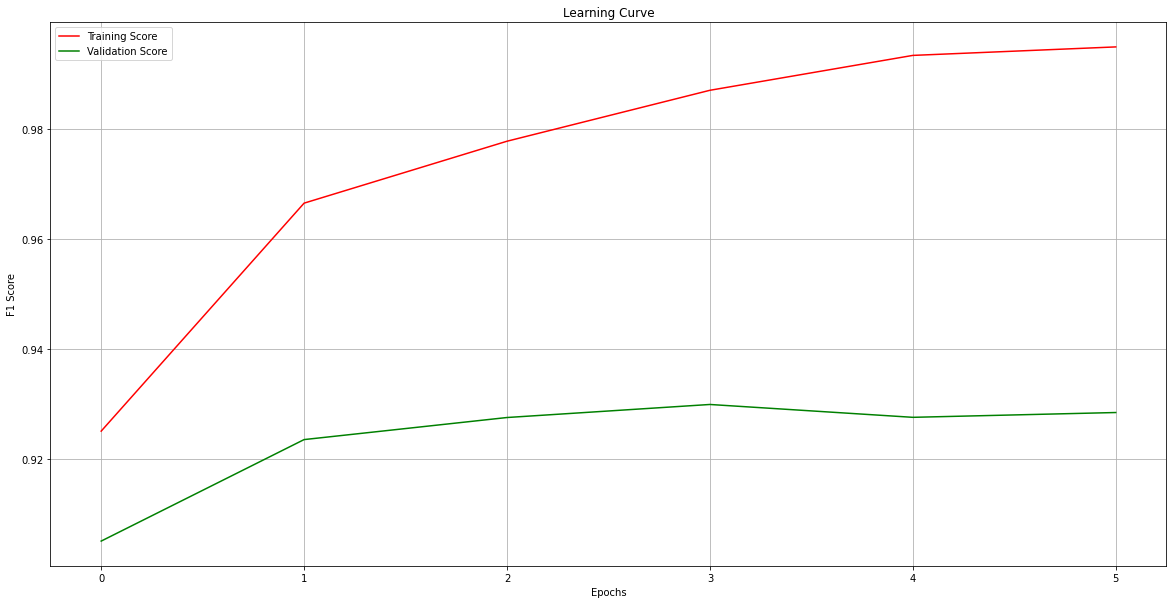

In [ ]:
_, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("Learning Curve")
axes.set_xlabel("Epochs")
axes.set_ylabel("F1 Score")
axes.grid()

axes.plot(epoch_sizes, train_scores, color="r", label="Training Score")
axes.plot(epoch_sizes, val_scores, color="g", label="Validation Score")
axes.legend(loc="best")

<ipython-input-64-4ae427ad0939>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-64-4ae427ad0939>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


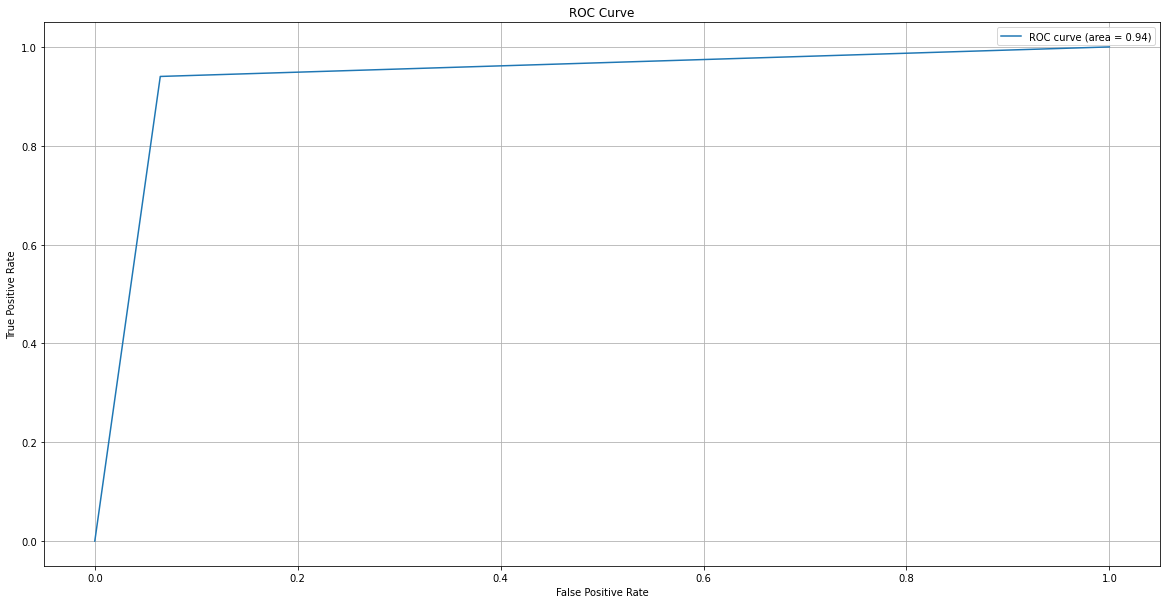

In [ ]:
from sklearn.metrics import roc_curve, auc
y_predicted = make_prediction(test_dataloader,model)
y_actual = test_dataset.getLabels()
fp,tp,_ = roc_curve(y_actual, y_predicted)
roc_auc = auc(fp,tp)

_, axes = plt.subplots(1,1,figsize=(20,10))
axes.set_title("ROC Curve")
axes.set_xlabel("False Positive Rate")
axes.set_ylabel("True Positive Rate")
axes.grid()
axes.plot(fp, tp, label='ROC curve (area = %0.2f)' % roc_auc)
axes.legend(loc = "best")

##Saving the model

In [ ]:
PATH = 'drive/MyDrive/ML/AI2/'
torch.save(model.state_dict(),PATH + 'myBERTmodel2.pt')

#Test the model on the imported dataset

In [ ]:
MODEL_PATH = 'drive/MyDrive/ML/AI2/'

Run the following blocks to test the performance on your own dataset:

1.   Imports
2.   Loading the data (adjust ```test_path```)
3.   Producing the Encodings through the BERT tokenizer
4.   Defining a custom dataset
5.   Testing Process
6.   Defining the structure of the classifier
7.   Alternative Architecture > 2 Layered Model definition
8.   Select and run below either of the two models


##1-Layer Model

In [ ]:
model = BertBinaryClassifier("bert-base-uncased",128,0.05)
model.load_state_dict(torch.load(MODEL_PATH + 'myBERTmodel.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

##2-Layer Model

In [ ]:
model = BERT2Layers("bert-base-uncased",256,128,0.05)
model.load_state_dict(torch.load(MODEL_PATH + 'myBERTmodel2.pt'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

##Results:

In [ ]:
precision, recall, f1 = Test_Network(test_dataloader,model)
print("Precision: ",precision.item())
print("Recall: ",recall.item())
print("f1 measure: ",f1.item())

<ipython-input-64-4ae427ad0939>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key,val in self.encodings.items()}
<ipython-input-64-4ae427ad0939>:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx])


Precision:  0.9328234195709229
Recall:  0.9403815269470215
f1 measure:  0.9346843361854553
